In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import harmonypy as hm
import scrublet as scr
from matplotlib import rcParams

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, color_map='viridis')
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.1.0
cffi                1.14.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
harmonypy           NA
igraph              0.7.1
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
jedi                0.16.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.2
llvmlite            0.34.0
matplotlib          3.2.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.1.1
numba               0.51.2
numexpr             2.7.2
numpy               1.19.2
packaging           20.9
pandas              1.1.5
parso               0.6.2
pexpect             4.8.

In [2]:
def DEG_table(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    return markers

In [3]:
def filtered_DEGs(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [4]:
def filtered_DEG_names(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [5]:
def filtered_down_reg_DEGs(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [6]:
def filtered_down_reg_DEG_names(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [7]:
adata_orig = sc.read_h5ad('./p1_zfish_ven_RAW.h5ad')


In [8]:
adata_orig

AnnData object with n_obs × n_vars = 3302 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch', 'leiden_01', 'leiden_011', 'leiden_012', 'leiden_013', 'leiden_014', 'leiden_015', 'leiden_016', 'leiden_017', 'leiden_018', 'leiden_019', 'leiden_02', 'leiden_021', 'leiden_022', 'leiden_023', 'leiden_024', 'leiden_025', 'leiden_026', 'leiden_027', 'leiden_028', 'leiden_029', 'leiden_03', 'leiden_031', 'leiden_032', 'leiden_033', 'leiden_034', 'leiden_035', 'leiden_036', 'leiden_037', 'leiden_038', 'leiden_039', 'leiden', 'leiden_annotation', 'cell_type'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_pca', 'X_umap'

In [9]:
adata = adata_orig.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()

adata = adata_orig

In [10]:
adata

AnnData object with n_obs × n_vars = 3302 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch', 'leiden_01', 'leiden_011', 'leiden_012', 'leiden_013', 'leiden_014', 'leiden_015', 'leiden_016', 'leiden_017', 'leiden_018', 'leiden_019', 'leiden_02', 'leiden_021', 'leiden_022', 'leiden_023', 'leiden_024', 'leiden_025', 'leiden_026', 'leiden_027', 'leiden_028', 'leiden_029', 'leiden_03', 'leiden_031', 'leiden_032', 'leiden_033', 'leiden_034', 'leiden_035', 'leiden_036', 'leiden_037', 'leiden_038', 'leiden_039', 'leiden', 'leiden_annotation', 'cell_type'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'

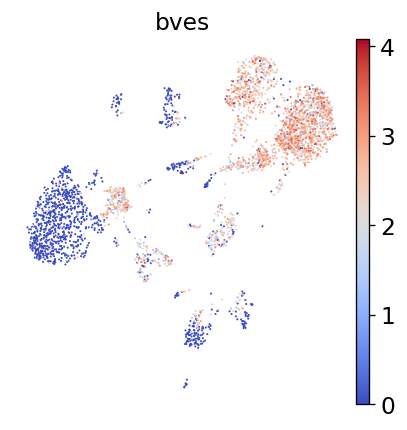

In [11]:
sc.pl.umap(adata, color = [ 'bves'      ], size = 6, legend_fontsize = 14, frameon = False, ncols=1, use_raw=True, color_map='coolwarm')